<a href="https://colab.research.google.com/github/mgraves236/neural-networks/blob/main/Sieci_neuronowe_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu stworzenie architektury sieci neuronowej oraz wytrenowanie jej wraz z doborem hiperparametrów tak, aby osiągnąć możliwie największe wartości wskazanych metryk.

Wykorzystywany dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data

26 191 elementów

In [ ]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

from keras.models import Sequential
import time

import tensorflow as tf

# 1. Pobranie danych

In [ ]:
# Usuwanie istniejących folderów

!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich

!wget https://www.dropbox.com/scl/fi/umlj0h521cc9rzeht1qyc/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi&dl=0
!unzip /content/Animals.zip?rlkey=fsdj4wxjov41er8a08md0o6pi

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: Animals/images/spider/OIP-E5zolQnxkNZoglB9Da8OHAHaE7.jpeg  
  inflating: Animals/images/spider/OIP-e6H3_aCtzXyxuExfwTHcVwHaE8.jpeg  
  inflating: Animals/images/spider/OIP-e6iXA-V3QbOBiNsPY-TfSQHaFj.jpeg  
  inflating: Animals/images/spider/OIP-E89tGEuaZ4wzBvIYvxOEjAHaGL.jpeg  
  inflating: Animals/images/spider/OIP-E-8HCNdrTI2Q-ujYynhRIgHaGZ.jpeg  
  inflating: Animals/images/spider/OIP-e8qNiF8Wvmqb-k9kucrzfAHaF4.jpeg  
  inflating: Animals/images/spider/OIP-e8x0rOA9DEq3agEGbUdwawHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e98qfAwKXAhDWF2DGtrA7gHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e9IDQCZespp1d4zQTNH-lwHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e9Mz3MvWwYqtYwC8bsmxIAHaF0.jpeg  
  inflating: Animals/images/spider/OIP-E9NM2O8ncDHm_M0iuVpfUgHaFj.jpeg  
  inflating: Animals/images/spider/OIP-e9UXRB7FVnKMmSaOmi__FwHaEw.jpeg  
  inflating: Animals/images/spider/OIP-Ea0THN3uA_gVU7hRslUP

# 2. Przygotowanie danych

In [ ]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Animals/images"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('cow', 1866), ('spider', 4821), ('elephant', 1446), ('cat', 1668), ('chicken', 3098), ('squirrel', 1862), ('dog', 4863), ('sheep', 1820), ('horse', 2623), ('butterfly', 2112)])

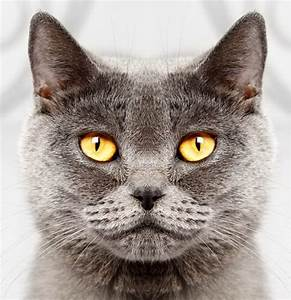

In [ ]:
# Wyświetlenie przykładowego obrazu

data_dir='/content/Animals/images'
path_dir=pathlib.Path(data_dir)
sample_img=list(path_dir.glob('cat/*'))[6]
Image.open(sample_img)

# W TYM MIEJSCU TRZEBA ZAMIENIĆ NASZE DANE NA DANE W POSTACI (train_images, train_labels), (test_images, test_labels)

albo znaleźć inny sposób :(

In [ ]:
# (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [ ]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

In [ ]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 277x277
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [ ]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

# 3. Wybranie modelu

In [ ]:
# 	MobileNetV3, VGG16

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8259762

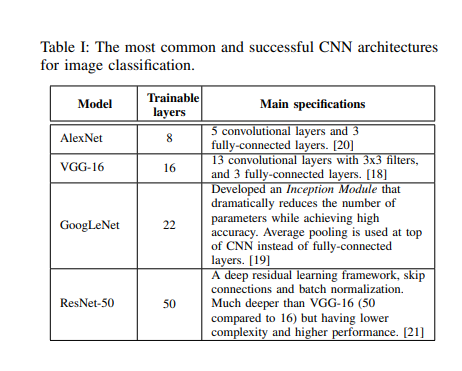

AlexNet
https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner

In [ ]:
alex_net = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# 4. Trenowanie modelu

In [ ]:
alex_net.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
alex_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [ ]:
alex_net.fit(train_ds,
          epochs=50,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/50


# 5. Ewaluacja

In [ ]:
alex_net.evaluate(test_ds)